In [1]:
import mitgcm_tools
import warnings
import numpy  as np
import xarray as xr

from scipy.interpolate import griddata
from scipy.ndimage     import gaussian_filter
from scipy.optimize    import curve_fit
from matplotlib        import pyplot  as plt

# Conversions
rhoconst     = 1024.5
perl_2_perkg = 1000/rhoconst # e.g. mol l-1 * 1000 l m-3 * 1/rho m3 kg-1 -> mol kg-1
perm3_2_perl = 1.0/1000   # e.g. mol m-3 * 1/1000 m3 l-1 -> mol l-1
molperm3_2_umolperkg=1e6/rhoconst

### Read in "data" namelist and initialize grid

In [2]:
data=mitgcm_tools.getparm('input/data')

# edit data file, depends on resolution now, so code dx- dy-spacing here
dx = np.ones(1440)*0.1
dy = np.ones(600) *0.1

XG=np.zeros((len(dy)  ,len(dx)+1))
YG=np.zeros((len(dy)+1,len(dx)  ))

XG[:,1:]=np.cumsum(np.ones((len(dy),len(dx)  ))*np.unique(dx)*10,axis=1)/10
YG[1:,:]=np.cumsum(np.ones((len(dy),len(dx)))*np.unique(dy)*10,axis=0)/10

XC=(np.cumsum(np.ones((len(dy),len(dx)))*np.unique(dx)*10,axis=1)/10)\
                                                                     -(np.unique(dx)/2)
YC=(np.cumsum(np.ones((len(dy),len(dx)))*np.unique(dy)*10,axis=0)/10)\
                                                                     -(np.unique(dy)/2)
#drF=data['delr']
drF=np.array((10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
              10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  
              10.,  10.,  10.,  10.,  10.,  10.,  11.,  13.,  15.,  19.,  
              25.,  32.,  40.,  49.,  59.,  69.,  77.,  84.,  90.,  94.,  
              97.,  99., 100., 101., 104., 111., 125., 144., 167., 192.,
             218., 245., 271., 297., 323., 349., 375., 401., 427., 453.))
rF=np.zeros(len(drF)+1)
rF[1:]=np.cumsum(drF)

# Interpolate RF to centers for RC
rC=np.interp(np.arange(0,len(rF)-1)+0.5,np.arange(0,len(rF)),rF)
rF

array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
        180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
        271.,  284.,  299.,  318.,  343.,  375.,  415.,  464.,  523.,
        592.,  669.,  753.,  843.,  937., 1034., 1133., 1233., 1334.,
       1438., 1549., 1674., 1818., 1985., 2177., 2395., 2640., 2911.,
       3208., 3531., 3880., 4255., 4656., 5083., 5536.])

### Initialize bathymetry
Load "depth_2d.bin" from the offline_run_template for basin shape

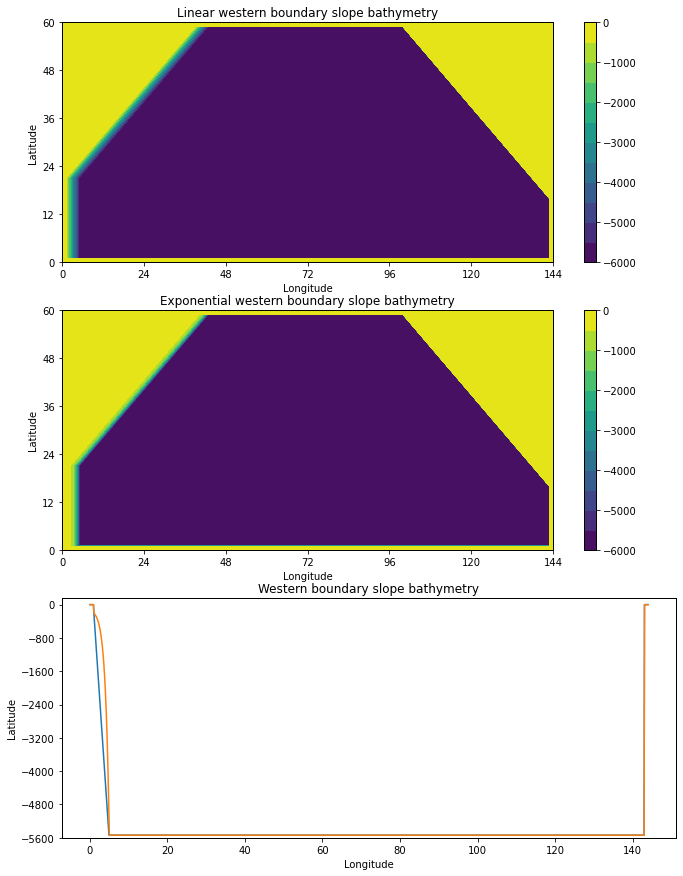

In [3]:
depth_linslp = np.nan_to_num(mitgcm_tools.open_bnfile('offline_run_template/depth_2d.bin',[600,1440],'>f8')) 
depth_expslp = np.nan_to_num(mitgcm_tools.open_bnfile('offline_run_template/depth_2d.bin',[600,1440],'>f8')) 

seafloor=np.max(rF)
depth_linslp=depth_linslp*(seafloor/100) # from -100m to -5500m
depth_expslp=depth_expslp*(seafloor/100) # from -100m to -5500m

# Add a 1 degree boundary around the edge to prevent periodicity
depth_linslp[  0:10,   :  ]=0
depth_linslp[-10:-1,   :  ]=0
depth_linslp[   :  ,  0:10]=0
depth_linslp[   :  ,-10:-1]=0

depth_expslp[  0:10,   :  ]=0
depth_expslp[-10:-1,   :  ]=0
depth_expslp[   :  ,  0:10]=0
depth_expslp[   :  ,-10:-1]=0

# Add the (linear) sloping continental shelf to the western boundary
for jj in np.arange(10,590):
    for ii in np.arange(10,50):
        dx=np.max((jj-201-10,0))
        depth_linslp[jj,ii+dx]=(-(ii-10)*(seafloor-200)/39)-200
        
# Add the (exponentially) sloping continental shelf to the western boundary
for jj in np.arange(9,590):
    dx=np.max((jj-201-10,0))
    depth_expslp[jj,10+dx:10+dx+40]=-(99+seafloor*np.exp(-4+np.arange(0.0,4.15,0.1)))[0:40]

f1, f1ax = plt.subplots(figsize=(11,15),ncols=1,nrows=3)
f1cax=f1ax.copy()
f1cax[0]=f1ax[0].contourf(XC,YC,depth_linslp,levels=np.arange(-6000,500,500),cmap='viridis')
plt.colorbar(f1cax[0],ax=f1ax[0])
f1ax[0].set(xlim=(0,144),xticks=np.arange(0,168,24),ylim=(0,60),yticks=np.arange(0,72,12),
            title='Linear western boundary slope bathymetry',xlabel='Longitude',ylabel='Latitude')
f1cax[1]=f1ax[1].contourf(XC,YC,depth_expslp,levels=np.arange(-6000,500,500),cmap='viridis')
plt.colorbar(f1cax[1],ax=f1ax[1])
f1ax[1].set(xlim=(0,144),xticks=np.arange(0,168,24),ylim=(0,60),yticks=np.arange(0,72,12),
            title='Exponential western boundary slope bathymetry',xlabel='Longitude',ylabel='Latitude')
f1ax[2].plot(XC[120,:],depth_linslp[120,:])
f1ax[2].plot(XC[120,:],depth_expslp[120,:])
f1ax[2].set(
    #xlim=(-8,152),xticks=np.arange(0,168,24),
    ylim=(-5600,160),yticks=np.arange(-5600,800,800),
            title='Western boundary slope bathymetry',xlabel='Longitude',ylabel='Latitude')
plt.show()


### Load climatologies for forcing
Linear annual-average temperature relaxation

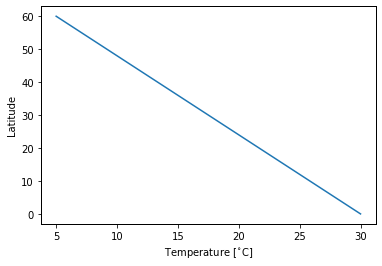

In [4]:
tref=30-(25/60)*YC
plt.plot(np.mean(tref,axis=1),np.mean(YC,axis=1))
plt.xlabel('Temperature [$^{\circ}$C]')
plt.ylabel('Latitude')
plt.show()

Use World Ocean Atlas 2013 Pacific data to make a seasonally varying version that averages out to the annual version above

read mask file at /Users/jml1/Dropbox_Work/Applications/python/mitgcm_tools/woa13_basinmask_01.msk found by searching python path.


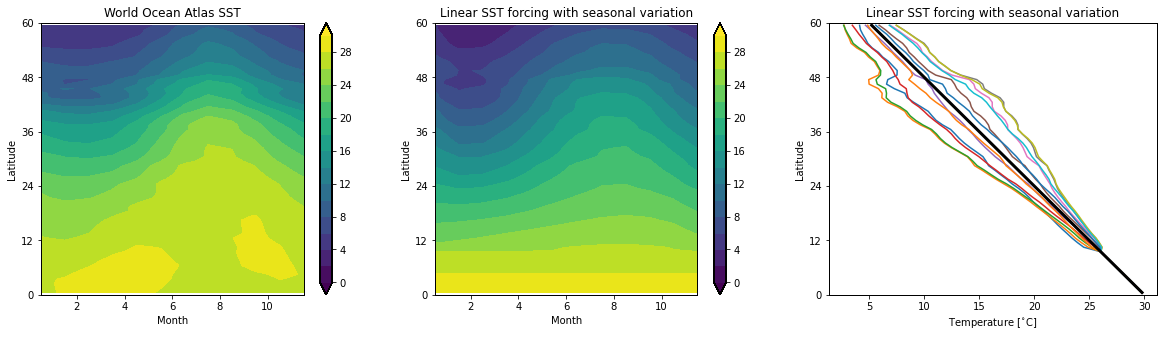

In [5]:
#url='https://data.nodc.noaa.gov/thredds/catalog/ncei/woa/temperature/decav/0.25/catalog.html?dataset=ncei/woa/temperature/decav/0.25/woa18_decav_t01_04.nc'
urlt='/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_monthly_temperature_v2.nc'
urls='/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_monthly_salinity_v2.nc'

woa13_data=xr.open_dataset(urlt,decode_times=False)
woa13s    =xr.open_dataset(urls,decode_times=False)
woa13_data['s_an']=woa13s['s_an']

tmp=woa13_data['lon'].values
tmp[tmp<0]=tmp[tmp<0]+360
tmp=np.sort(tmp)
woa13_data=woa13_data.roll(lon=180,roll_coords=False)
woa13_data['lon']=tmp

yc,xc=np.meshgrid(woa13_data.lat.values,woa13_data.lon.values)
atlantic_mask, pacific_mask, indian_mask, so_mask, arctic_mask = mitgcm_tools.oceanmasks(xc,yc,np.isfinite(woa13_data.t_an).isel(time=0).T.values)
woa13_data['atlantic_mask'] = xr.DataArray(atlantic_mask, coords=[woa13_data.lon.data, woa13_data.lat.data, woa13_data.depth.data], dims=['lon', 'lat', 'depth'])
woa13_data['pacific_mask']  = xr.DataArray(pacific_mask , coords=[woa13_data.lon.data, woa13_data.lat.data, woa13_data.depth.data], dims=['lon', 'lat', 'depth'])
woa13_data['indian_mask']   = xr.DataArray(indian_mask  , coords=[woa13_data.lon.data, woa13_data.lat.data, woa13_data.depth.data], dims=['lon', 'lat', 'depth'])
woa13_data['so_mask']       = xr.DataArray(so_mask      , coords=[woa13_data.lon.data, woa13_data.lat.data, woa13_data.depth.data], dims=['lon', 'lat', 'depth'])
woa13_data['arctic_mask']   = xr.DataArray(arctic_mask  , coords=[woa13_data.lon.data, woa13_data.lat.data, woa13_data.depth.data], dims=['lon', 'lat', 'depth'])

trmon=np.tile(30-(25/60)*np.arange(0.5,60.5,1),[12,1]).T

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    ii=5
    for elat in np.arange(5.5,60.5,1):
        if np.abs(woa13_data.t_an.isel(depth=0).where(woa13_data.pacific_mask.isel(depth=0)==0).where(woa13_data.lat>=0).mean('lon').sel(lat=elat,method='nearest').max() - 
                  woa13_data.t_an.isel(depth=0).where(woa13_data.pacific_mask.isel(depth=0)==0).where(woa13_data.lat>=0).mean('lon').sel(lat=elat,method='nearest').min()) > 1.750:
            coef = np.polyfit(np.arange(0.5,12.5,1), woa13_data.t_an.isel(depth=0).where(woa13_data.pacific_mask.isel(depth=0)==0).where(woa13_data.lat>=0).mean('lon').sel(lat=elat,method='nearest'), 4)
            seas = coef[0]*np.arange(0.5,12.5,1)**4 \
                  +coef[1]*np.arange(0.5,12.5,1)**3 \
                  +coef[2]*np.arange(0.5,12.5,1)**2 \
                  +coef[3]*np.arange(0.5,12.5,1)    \
                  +coef[4]
            # make sure seasonal variation is smooth from DEC - JAN
            seas[-1]=np.mean((seas[0],seas[-2]))
            # make sure the mean of seasonal variations matches the annual-average reference
            trmon[ii,:]=seas-np.mean(seas)+trmon[ii,0]
        ii += 1

# Tile the latitudinal profiles along the longitudinal direction
trmon=np.tile(trmon[:,np.newaxis,:],[1,144,1])

f2, f2ax = plt.subplots(figsize=(20,5),ncols=3,nrows=1)
f2cax=f2ax.copy()
f2cax[0]=f2ax[0].contourf(np.arange(0.5,12.5,1),woa13_data.lat.isel(lat=slice(90,150)),woa13_data.t_an.isel(depth=0).where(woa13_data.pacific_mask.isel(depth=0)==0).isel(lat=slice(90,150)).mean('lon').T,levels=np.arange(0,32,2),cmap='viridis',extend='both')
plt.colorbar(f2cax[0],ax=f2ax[0])
f2ax[0].set(ylim=(0,60),yticks=np.arange(0,72,12),
            title='World Ocean Atlas SST',xlabel='Month',ylabel='Latitude')
f2cax[1]=f2ax[1].contourf(np.arange(0.5,12.5,1),woa13_data.lat.isel(lat=slice(90,150)),np.mean(trmon,axis=1),levels=np.arange(0,32,2),cmap='viridis',extend='both')
plt.colorbar(f2cax[1],ax=f2ax[1])
f2ax[1].set(ylim=(0,60),yticks=np.arange(0,72,12),
            title='Linear SST forcing with seasonal variation',xlabel='Month',ylabel='Latitude')
f2ax[2].plot(np.mean(trmon,axis=1),np.tile(np.arange(0.5,60.5,1),[12,1]).T)
f2ax[2].plot(np.mean(np.mean(trmon,axis=1),axis=1),np.arange(0.5,60.5,1),color='black',linewidth=3)
f2ax[2].set(ylim=(0,60),yticks=np.arange(0,72,12),
            title='Linear SST forcing with seasonal variation',xlabel='Temperature [$^{\circ}$C]',ylabel='Latitude')
plt.show()

Salinity relaxation doesn't change that much over a year, so could just prescribe a step-function with latitude

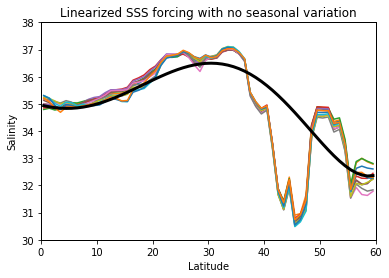

In [6]:
# Fit surface salinity to a 5th order polynomial, it gives the best distribution of low S at the equator,
# higher in the midlats and low again in the subpolar regions.
def objective(x, a, b, c, d, e, f):  return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

popt, pcov = curve_fit(objective, woa13_data.lat.isel(lat=slice(78,150)).values+5,
                                   woa13_data.s_an.isel(depth=0).where(woa13_data.pacific_mask.isel(depth=0)==0).isel(lat=slice(78,150)).mean({'lon','time'}).values)
fitfunc = lambda x: (popt[0] * x) + (popt[1] * x**2) + (popt[2] * x**3) + (popt[3] * x**4) + (popt[4] * x**5) + popt[5]
srmon = np.tile(fitfunc(woa13_data.lat.isel(lat=slice(90,150)).values)[:,np.newaxis,np.newaxis],(1,144,12))

plt.plot(woa13_data.lat.isel(lat=slice(90,150)),woa13_data.s_an.isel(depth=0).where(woa13_data.pacific_mask.isel(depth=0)==0).isel(lat=slice(90,150)).mean('lon').T)
plt.plot(woa13_data.lat.isel(lat=slice(90,150)),srmon[:,0,0],color='k',linewidth=3)
plt.xlim(0,60)
plt.ylim(30,38)
plt.title('Linearized SSS forcing with no seasonal variation')
plt.xlabel('Latitude')
plt.ylabel('Salinity')
plt.show()

Zonal wind stress is latitudinally, and seasonally variable, but meridional wind stress is probably better off being constant

read mask file at /Users/jml1/Dropbox_Work/Applications/python/mitgcm_tools/woa13_basinmask_01.msk found by searching python path.
read mask file at /Users/jml1/Dropbox_Work/Applications/python/mitgcm_tools/woa13_basinmask_01.msk found by searching python path.
read mask file at /Users/jml1/Dropbox_Work/Applications/python/mitgcm_tools/woa13_basinmask_01.msk found by searching python path.


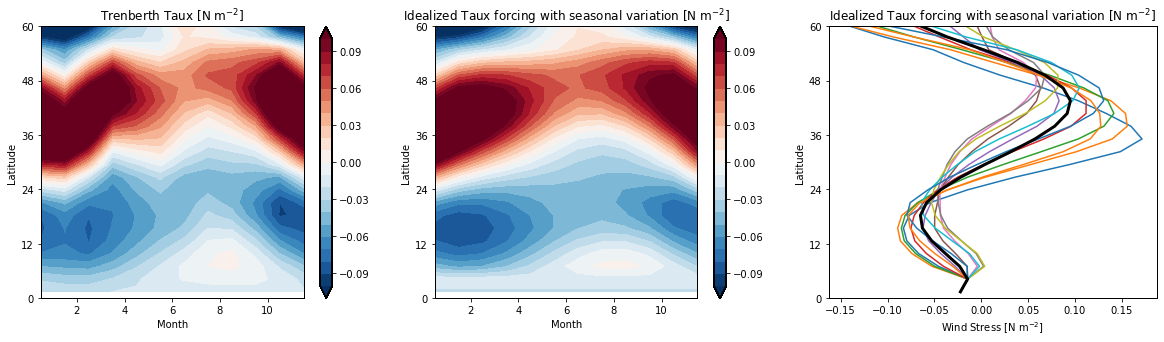

In [7]:
#urlwx='/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/core_v2_1949-2006_mean.nc'
#core=xr.open_dataset(urlwx,decode_times=False)
# load Trenberth winds because they're in the right units.
grid_data,xgrid=mitgcm_tools.loadgrid('/Users/jml1/Dropbox_Work/cfluxes_matlab/model_kpp/grid.glob.nc')
grid_data=grid_data.transpose('XC','XG','YC','YG','ZC','ZG','ZL','ZR')

taux = xr.DataArray(mitgcm_tools.open_bnfile('/Users/jml1/Dropbox_Work/cfluxes_matlab/model_kpp/tren_taux.bin',[12,64,128],'>f4'),
                    coords=[woa13_data.time.data, grid_data.YC.data, grid_data.XC.data], dims=['time', 'YC', 'XC'])
tauy = xr.DataArray(mitgcm_tools.open_bnfile('/Users/jml1/Dropbox_Work/cfluxes_matlab/model_kpp/tren_tauy.bin',[12,64,128],'>f4'),
                    coords=[woa13_data.time.data, grid_data.YC.data, grid_data.XC.data], dims=['time', 'YC', 'XC'])

# fit the zonally- and annually-averaged zonal wind stress profile and use as the reference
coef = np.polyfit(grid_data.YC.isel(YC=slice(32,54)),taux.where(grid_data.cmask_pacific.isel(ZC=0)==1).isel(YC=slice(32,54)).mean({"time",'XC'}),5)
ref  = coef[0]*grid_data.YC.isel(YC=slice(32,54))**5 \
      +coef[1]*grid_data.YC.isel(YC=slice(32,54))**4 \
      +coef[2]*grid_data.YC.isel(YC=slice(32,54))**3 \
      +coef[3]*grid_data.YC.isel(YC=slice(32,54))**2 \
      +coef[4]*grid_data.YC.isel(YC=slice(32,54))    \
      +coef[5]

txmon=np.tile(ref,[12,1]).T

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    ii=0
    for elat in grid_data.YC.isel(YC=slice(32,54)):
        if np.abs(taux.where(grid_data.cmask_pacific.isel(ZC=0)==1).mean('XC').sel(YC=elat,method='nearest').max() - 
                  taux.where(grid_data.cmask_pacific.isel(ZC=0)==1).mean('XC').sel(YC=elat,method='nearest').min()) > 0.05:
            coef = np.polyfit(np.arange(0.5,12.5,1),taux.where(grid_data.cmask_pacific.isel(ZC=0)==1).mean('XC').sel(YC=elat,method='nearest'),4)
            seas = coef[0]*np.arange(0.5,12.5,1)**4 \
                  +coef[1]*np.arange(0.5,12.5,1)**3 \
                  +coef[2]*np.arange(0.5,12.5,1)**2 \
                  +coef[3]*np.arange(0.5,12.5,1)    \
                  +coef[4]
            # make sure seasonal variation is smooth from DEC - JAN
            seas[-1]=np.mean((seas[0],seas[-2]))
            # make sure the mean of seasonal variations matches the annual-average reference
            txmon[ii,:]=seas-np.mean(seas)+ref[ii].values
        ii += 1

# Tile the latitudinal profiles along the longitudinal direction
txmon=np.tile(txmon[:,np.newaxis,:],[1,53,1])
tymon=np.zeros_like(txmon)

f4, f4ax = plt.subplots(figsize=(20,5),ncols=3,nrows=1)
f4cax=f4ax.copy()
f4cax[0]=f4ax[0].contourf(np.arange(0.5,12.5,1),taux.YC.isel(YC=slice(32,54)),taux.where(grid_data.cmask_pacific.isel(ZC=0)==1).isel(YC=slice(32,54)).mean({'XC'}).T,levels=np.arange(-0.1,0.11,0.01),cmap='RdBu_r',extend='both')
plt.colorbar(f4cax[0],ax=f4ax[0])
f4ax[0].set(ylim=(0,60),yticks=np.arange(0,72,12),
            title='Trenberth Taux [N m$^{-2}$]',xlabel='Month',ylabel='Latitude')
f4cax[1]=f4ax[1].contourf(np.arange(0.5,12.5,1),taux.YC.isel(YC=slice(32,54)),np.mean(txmon,axis=1),levels=np.arange(-0.1,0.11,0.01),cmap='RdBu_r',extend='both')
plt.colorbar(f4cax[1],ax=f4ax[1])
f4ax[1].set(ylim=(0,60),yticks=np.arange(0,72,12),
            title='Idealized Taux forcing with seasonal variation [N m$^{-2}$]',xlabel='Month',ylabel='Latitude')
f4ax[2].plot(np.mean(txmon,axis=1),np.tile(taux.YC.isel(YC=slice(32,54)),[12,1]).T)
f4ax[2].plot(np.mean(np.mean(txmon,axis=1),axis=1),taux.YC.isel(YC=slice(32,54)),color='black',linewidth=3)
f4ax[2].set(ylim=(0,60),yticks=np.arange(0,72,12),
            title='Idealized Taux forcing with seasonal variation [N m$^{-2}$]',xlabel='Wind Stress [N m$^{-2}$]',ylabel='Latitude')
plt.show()

Sponge Layer boundary conditions for T and S at the Southern Boundary maintain stratification

read mask file at /Users/jml1/Dropbox_Work/Applications/python/mitgcm_tools/woa13_basinmask_01.msk found by searching python path.


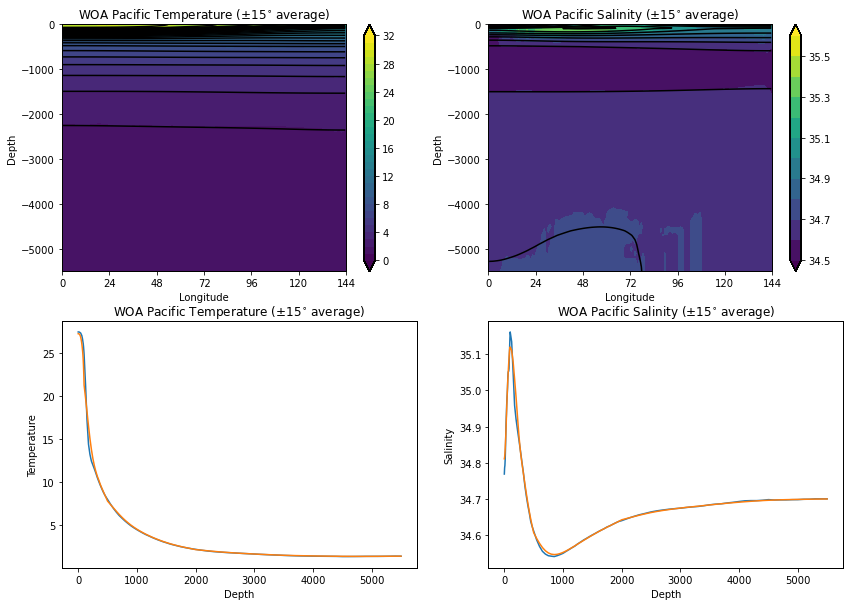

In [8]:
# Data locations (could be WOA urls)
urlta='/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_annual_temperature.nc'
urlsa='/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_annual_salinity.nc'

#urltm='/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_monthly_temperature.nc'
#urlsm='/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_monthly_salinity.nc'

# Load the annual climatology. This will do for the non-seasonal southern BC, but the seasonal data only covers the upper 1500m
woa13_sponge         = xr.open_dataset(urlta,decode_times=False).drop({'t_dd','t_gp','t_mn','t_oa','t_sd','t_se'})
woa13_sponge['s_an'] = xr.open_dataset(urlsa,decode_times=False)['s_an']

#woa13_ann         = xr.open_dataset(urlta,decode_times=False).drop({'t_dd','t_gp','t_mn','t_oa','t_sd','t_se'})
#woa13_ann['s_an'] = xr.open_dataset(urlsa,decode_times=False)['s_an']

## Tile the full depth annual fields and then substitute the upper 1500m from the monthly climatology
#woa13_sponge = woa13_ann.drop({'t_an','s_an'}).squeeze('time')
#woa13_sponge['time'] = np.arange(0.5,12.5,1.0)  
#woa13_sponge['t_mon']= xr.DataArray(np.tile(woa13_ann['t_an'],[12,1,1,1]),
#                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data], 
#                                    dims=['time','depth','lat', 'lon'])
#woa13_sponge['s_mon']= xr.DataArray(np.tile(woa13_ann['s_an'],[12,1,1,1]), 
#                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data],
#                                    dims=['time','depth','lat', 'lon'])
#woa13_sponge['t_mon'][:,0:57,:,:] = xr.open_dataset(urltm,decode_times=False)['t_an'].data
#woa13_sponge['s_mon'][:,0:57,:,:] = xr.open_dataset(urlsm,decode_times=False)['s_an'].data
#
woa13_sponge=woa13_sponge.roll(lon=180,roll_coords=False)
woa13_sponge=woa13_sponge.assign_coords(lon=(((woa13_sponge.lon + 180) % 360)))
#
## Smooth the data using a median filter
##woa13_sponge['t_mon'] = xr.DataArray(gaussian_filter(woa13_sponge['t_mon'].data,sigma=(0.1,0.5,0.75,0.75),mode='nearest'),
##                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data],
##                                    dims=['time','depth','lat', 'lon'])
##woa13_sponge['s_mon'] = xr.DataArray(gaussian_filter(woa13_sponge['s_mon'].data,sigma=(0.1,0.5,0.75,0.75),mode='nearest'),
##                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data],
##                                    dims=['time','depth','lat', 'lon'])

yc,xc=np.meshgrid(woa13_sponge.lat.values,woa13_sponge.lon.values)
atlantic_mask, pacific_mask, indian_mask, so_mask, arctic_mask = mitgcm_tools.oceanmasks(xc,yc,np.isfinite(woa13_sponge.t_an).isel(time=0).T.values)
woa13_sponge['atlantic_mask'] = xr.DataArray(atlantic_mask, 
                                             coords=[woa13_sponge.lon.data, woa13_sponge.lat.data, woa13_sponge.depth.data], 
                                             dims=['lon', 'lat', 'depth'])
woa13_sponge['pacific_mask']  = xr.DataArray(pacific_mask , 
                                             coords=[woa13_sponge.lon.data, woa13_sponge.lat.data, woa13_sponge.depth.data], 
                                             dims=['lon', 'lat', 'depth'])
woa13_sponge['indian_mask']   = xr.DataArray(indian_mask  , 
                                             coords=[woa13_sponge.lon.data, woa13_sponge.lat.data, woa13_sponge.depth.data], 
                                             dims=['lon', 'lat', 'depth'])
woa13_sponge['so_mask']       = xr.DataArray(so_mask      , 
                                             coords=[woa13_sponge.lon.data, woa13_sponge.lat.data, woa13_sponge.depth.data], 
                                             dims=['lon', 'lat', 'depth'])
woa13_sponge['arctic_mask']   = xr.DataArray(arctic_mask  , 
                                             coords=[woa13_sponge.lon.data, woa13_sponge.lat.data, woa13_sponge.depth.data], 
                                             dims=['lon', 'lat', 'depth'])
kernal=(2.5,25)
tsmooth = gaussian_filter(woa13_sponge.t_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").mean("time").ffill('depth'),
                              sigma=kernal)
ssmooth = gaussian_filter(woa13_sponge.s_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").mean("time").ffill('depth'),
                              sigma=kernal)

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    f3, f3ax = plt.subplots(figsize=(14,10),ncols=2,nrows=2)
    f3cax=f3ax.copy()
    f3cax[0,0]=f3ax[0,0].contourf(np.arange(0.5,144.5,1),-woa13_sponge.depth,woa13_sponge.t_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").mean("time").ffill('depth'),
                             levels=np.arange(0,33,1),cmap='viridis',extend='both')
    plt.colorbar(f3cax[0,0],ax=f3ax[0,0])
    f3ax[0,0].set(xlim=(0,144),xticks=np.arange(0,168,24),
                title='WOA Pacific Temperature ($\pm$15$^{\circ}$ average)',xlabel='Longitude',ylabel='Depth')
    f3cax[0,1]=f3ax[0,1].contourf(np.arange(0.5,144.5,1),-woa13_sponge.depth,woa13_sponge.s_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").mean("time").ffill('depth'),
                             levels=np.arange(34.5,35.6,0.1),cmap='viridis',extend='both')
    plt.colorbar(f3cax[0,1],ax=f3ax[0,1])
    
    f3cax[0,0]=f3ax[0,0].contour(np.arange(0.5,144.5,1),-woa13_sponge.depth,tsmooth,
                                  levels=np.arange(0,33,1),colors='k',extend='both')
    f3cax[0,1]=f3ax[0,1].contour(np.arange(0.5,144.5,1),-woa13_sponge.depth,ssmooth,
                                  levels=np.arange(34.5,35.6,0.1),colors='k',extend='both')
    
    f3ax[0,1].set(xlim=(0,144),xticks=np.arange(0,168,24),
                title='WOA Pacific Salinity ($\pm$15$^{\circ}$ average)',xlabel='Longitude',ylabel='Depth')
    f3ax[1,0].plot(woa13_sponge.depth,woa13_sponge.t_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").ffill('depth').median("lon").T)
    f3ax[1,0].plot(woa13_sponge.depth,np.median(tsmooth,axis=1))
    f3ax[1,0].set(
                title='WOA Pacific Temperature ($\pm$15$^{\circ}$ average)',xlabel='Depth',ylabel='Temperature')
    f3ax[1,1].plot(woa13_sponge.depth,woa13_sponge.s_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").ffill('depth').median("lon").T)
    f3ax[1,1].plot(woa13_sponge.depth,np.median(ssmooth,axis=1))
    f3ax[1,1].set(
                title='WOA Pacific Salinity ($\pm$15$^{\circ}$ average)',xlabel='Depth',ylabel='Salinity')
    plt.show()

As well as nutrient fields

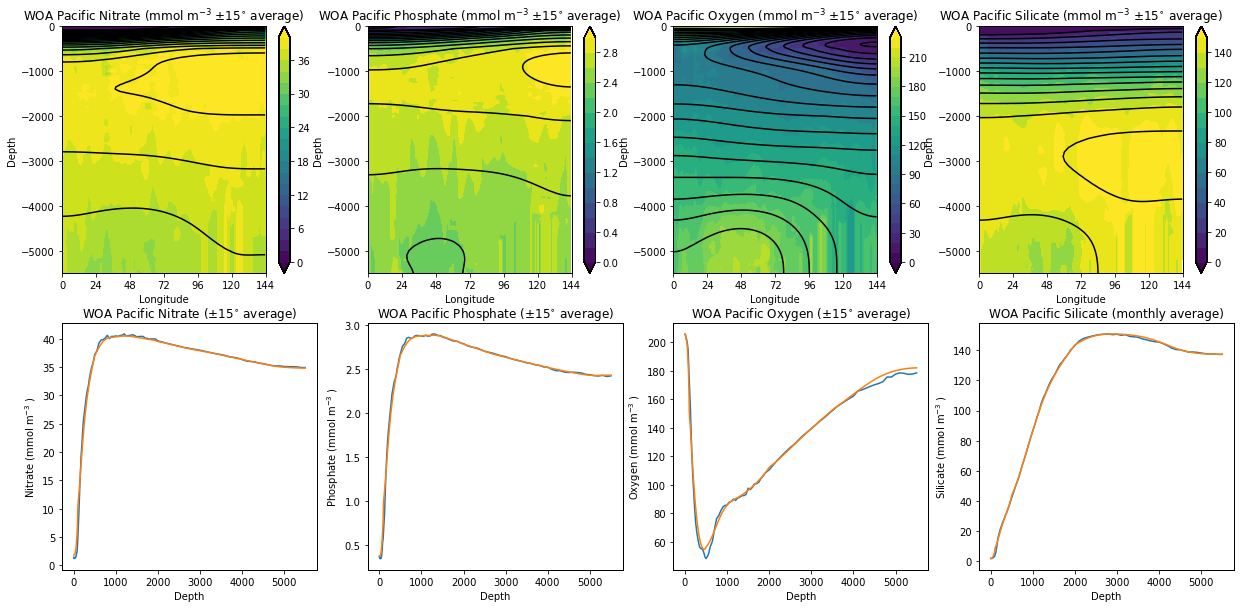

In [9]:
urlna = '/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_annual_nitrate.nc'
#urlnm = '/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_monthly_nitrate.nc'
urlpa = '/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_annual_phosphate.nc'
#urlpm = '/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_monthly_phosphate.nc'
urloa = '/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_annual_oxygen.nc'
#urlom = '/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_monthly_oxygen.nc'
urlia = '/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_annual_silicate.nc'
#urlim = '/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_monthly_silicate.nc'

woa13_sponge['n_an'] = xr.DataArray((xr.open_dataset(urlna,decode_times=False)['n_an'].roll(lon=180,roll_coords=False))*perl_2_perkg/molperm3_2_umolperkg,
                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data], 
                                    dims=['time','depth','lat', 'lon'])
woa13_sponge['p_an'] = xr.DataArray((xr.open_dataset(urlpa,decode_times=False)['p_an'].roll(lon=180,roll_coords=False))*perl_2_perkg/molperm3_2_umolperkg,
                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data], 
                                    dims=['time','depth','lat', 'lon'])
woa13_sponge['o_an'] = xr.DataArray((xr.open_dataset(urloa,decode_times=False)['o_an'].roll(lon=180,roll_coords=False))*44.61*perl_2_perkg/molperm3_2_umolperkg,
                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data], 
                                    dims=['time','depth','lat', 'lon'])
woa13_sponge['i_an'] = xr.DataArray((xr.open_dataset(urlia,decode_times=False)['i_an'].roll(lon=180,roll_coords=False))*perl_2_perkg/molperm3_2_umolperkg,
                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data], 
                                    dims=['time','depth','lat', 'lon'])

#woa13_ann['n_an'] = xr.open_dataset(urlna,decode_times=False)['n_an']*perl_2_perkg/molperm3_2_umolperkg
#woa13_ann['p_an'] = xr.open_dataset(urlpa,decode_times=False)['p_an']*perl_2_perkg/molperm3_2_umolperkg
#woa13_ann['o_an'] = xr.open_dataset(urloa,decode_times=False)['o_an']*44.61*perl_2_perkg/molperm3_2_umolperkg
#woa13_ann['i_an'] = xr.open_dataset(urlia,decode_times=False)['i_an']*perl_2_perkg/molperm3_2_umolperkg
#
#woa13_sponge['n_mon']= xr.DataArray(np.tile(woa13_ann['n_an'].roll(lon=180,roll_coords=False),[12,1,1,1]),
#                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data], 
#                                    dims=['time','depth','lat', 'lon'])
#woa13_sponge['p_mon']= xr.DataArray(np.tile(woa13_ann['p_an'].roll(lon=180,roll_coords=False),[12,1,1,1]),
#                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data], 
#                                    dims=['time','depth','lat', 'lon'])
#woa13_sponge['o_mon']= xr.DataArray(np.tile(woa13_ann['o_an'].roll(lon=180,roll_coords=False),[12,1,1,1]),
#                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data], 
#                                    dims=['time','depth','lat', 'lon'])
#woa13_sponge['i_mon']= xr.DataArray(np.tile(woa13_ann['i_an'].roll(lon=180,roll_coords=False),[12,1,1,1]),
#                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data], 
#                                    dims=['time','depth','lat', 'lon'])
#
#woa13_sponge['n_mon'][:,0:37,:,:] = xr.open_dataset(urlnm,decode_times=False)['n_an'].roll(lon=180,roll_coords=False).data*perl_2_perkg/molperm3_2_umolperkg
#woa13_sponge['p_mon'][:,0:37,:,:] = xr.open_dataset(urlpm,decode_times=False)['p_an'].roll(lon=180,roll_coords=False).data*perl_2_perkg/molperm3_2_umolperkg
#woa13_sponge['o_mon'][:,0:57,:,:] = xr.open_dataset(urlom,decode_times=False)['o_an'].roll(lon=180,roll_coords=False).data*44.61*perl_2_perkg/molperm3_2_umolperkg
#woa13_sponge['i_mon'][:,0:37,:,:] = xr.open_dataset(urlim,decode_times=False)['i_an'].roll(lon=180,roll_coords=False).data*perl_2_perkg/molperm3_2_umolperkg
#
#
##kernal=(0.5,0.25,1.5,1.5)
##woa13_sponge['n_mon'] = xr.DataArray(gaussian_filter(woa13_sponge['n_mon'].data,sigma=kernal),
##                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data],
##                                    dims=['time','depth','lat', 'lon'])
##woa13_sponge['p_mon'] = xr.DataArray(gaussian_filter(woa13_sponge['p_mon'].data,sigma=kernal),
##                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data],
##                                    dims=['time','depth','lat', 'lon'])
##woa13_sponge['o_mon'] = xr.DataArray(gaussian_filter(woa13_sponge['o_mon'].data,sigma=kernal),
##                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data],
##                                    dims=['time','depth','lat', 'lon'])
##woa13_sponge['i_mon'] = xr.DataArray(gaussian_filter(woa13_sponge['i_mon'].data,sigma=kernal),
##                                    coords=[woa13_sponge.time.data, woa13_sponge.depth.data, woa13_sponge.lat.data, woa13_sponge.lon.data],
##                                    dims=['time','depth','lat', 'lon'])
kernal=(2.5,25)
nsmooth = gaussian_filter(woa13_sponge.n_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)) \
                              .median("lat").mean("time").ffill('depth'),
                              sigma=kernal)
psmooth = gaussian_filter(woa13_sponge.p_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)) \
                              .median("lat").mean("time").ffill('depth'),
                              sigma=kernal)
osmooth = gaussian_filter(woa13_sponge.o_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)) \
                              .median("lat").mean("time").ffill('depth'),
                              sigma=kernal)
ismooth = gaussian_filter(woa13_sponge.i_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)) \
                              .median("lat").mean("time").ffill('depth'),
                              sigma=kernal)

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    f4, f4ax = plt.subplots(figsize=(21,10),ncols=4,nrows=2)
    f4cax=f4ax.copy()
    f4cax[0,0]=f4ax[0,0].contourf(np.arange(0.5,144.5,1),-woa13_sponge.depth,1000*woa13_sponge.n_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").mean("time").ffill('depth'),
                             levels=np.arange(0,42,2),cmap='viridis',extend='both')
    plt.colorbar(f4cax[0,0],ax=f4ax[0,0])
    f4ax[0,0].set(xlim=(0,144),xticks=np.arange(0,168,24),
                title='WOA Pacific Nitrate (mmol m$^{-3}$ $\pm$15$^{\circ}$ average)',xlabel='Longitude',ylabel='Depth')
    f4cax[0,1]=f4ax[0,1].contourf(np.arange(0.5,144.5,1),-woa13_sponge.depth,1000*woa13_sponge.p_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").mean("time").ffill('depth'),
                             levels=np.arange(0,3.2,0.2),cmap='viridis',extend='both')
    plt.colorbar(f4cax[0,1],ax=f4ax[0,1])
    f4ax[0,1].set(xlim=(0,144),xticks=np.arange(0,168,24),
                title='WOA Pacific Phosphate (mmol m$^{-3}$ $\pm$15$^{\circ}$ average)',xlabel='Longitude',ylabel='Depth')
    f4cax[0,2]=f4ax[0,2].contourf(np.arange(0.5,144.5,1),-woa13_sponge.depth,1000*woa13_sponge.o_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").mean("time").ffill('depth'),
                             levels=np.arange(0,240,10),cmap='viridis',extend='both')
    plt.colorbar(f4cax[0,2],ax=f4ax[0,2])
    f4ax[0,2].set(xlim=(0,144),xticks=np.arange(0,168,24),
                title='WOA Pacific Oxygen (mmol m$^{-3}$ $\pm$15$^{\circ}$ average)',xlabel='Longitude',ylabel='Depth')
    f4cax[0,3]=f4ax[0,3].contourf(np.arange(0.5,144.5,1),-woa13_sponge.depth,1000*woa13_sponge.i_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").mean("time").ffill('depth'),
                              levels=np.arange(0,160,10),cmap='viridis',extend='both')
    plt.colorbar(f4cax[0,3],ax=f4ax[0,3])
    f4ax[0,3].set(xlim=(0,144),xticks=np.arange(0,168,24),
                title='WOA Pacific Silicate (mmol m$^{-3}$ $\pm$15$^{\circ}$ average)',xlabel='Longitude',ylabel='Depth')

    f4cax[0,0]=f4ax[0,0].contour(np.arange(0.5,144.5,1),-woa13_sponge.depth,1000*nsmooth,
                              levels=np.arange(0,42,2),colors='k',extend='both')
    f4cax[0,1]=f4ax[0,1].contour(np.arange(0.5,144.5,1),-woa13_sponge.depth,1000*psmooth,
                              levels=np.arange(0,3.2,0.2),colors='k',extend='both')
    f4cax[0,2]=f4ax[0,2].contour(np.arange(0.5,144.5,1),-woa13_sponge.depth,1000*osmooth,
                              levels=np.arange(0,240,10),colors='k',extend='both')
    f4cax[0,3]=f4ax[0,3].contour(np.arange(0.5,144.5,1),-woa13_sponge.depth,1000*ismooth,
                              levels=np.arange(0,160,10),colors='k',extend='both')
    
    f4ax[1,0].plot(woa13_sponge.depth,1000*woa13_sponge.n_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").ffill('depth').median("lon").T)
    f4ax[1,0].plot(woa13_sponge.depth,1000*np.median(nsmooth,axis=1))
    f4ax[1,0].set(
                title='WOA Pacific Nitrate ($\pm$15$^{\circ}$ average)',xlabel='Depth',ylabel='Nitrate (mmol m$^{-3}$ )')
    f4ax[1,1].plot(woa13_sponge.depth,1000*woa13_sponge.p_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").ffill('depth').median("lon").T)
    f4ax[1,1].plot(woa13_sponge.depth,1000*np.median(psmooth,axis=1))
    f4ax[1,1].set(
                title='WOA Pacific Phosphate ($\pm$15$^{\circ}$ average)',xlabel='Depth',ylabel='Phosphate (mmol m$^{-3}$ )')
    f4ax[1,2].plot(woa13_sponge.depth,1000*woa13_sponge.o_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").ffill('depth').median("lon").T)
    f4ax[1,2].plot(woa13_sponge.depth,1000*np.median(osmooth,axis=1))
    f4ax[1,2].set(
                title='WOA Pacific Oxygen ($\pm$15$^{\circ}$ average)',xlabel='Depth',ylabel='Oxygen (mmol m$^{-3}$ )')
    f4ax[1,3].plot(woa13_sponge.depth,1000*woa13_sponge.i_an \
                              .where(woa13_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").ffill('depth').median("lon").T)
    f4ax[1,3].plot(woa13_sponge.depth,1000*np.median(ismooth,axis=1))
    f4ax[1,3].set(
                title='WOA Pacific Silicate (monthly average)',xlabel='Depth',ylabel='Silicate (mmol m$^{-3}$ )')
    plt.show()

...plus carbon and alkalinity

read mask file at /Users/jml1/Dropbox_Work/Applications/python/mitgcm_tools/woa13_basinmask_01.msk found by searching python path.


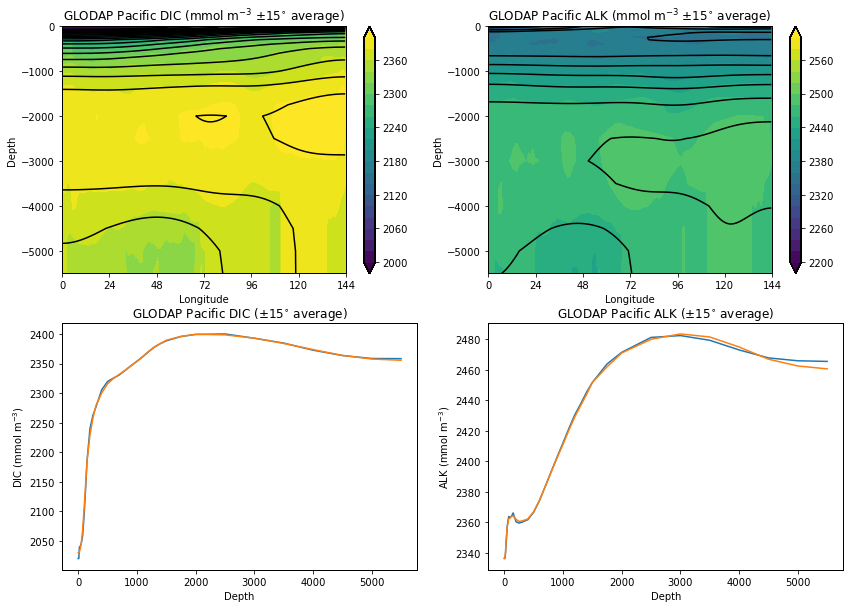

In [10]:
urlaa = '/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/GLODAPv2.2016b.TAlk.nc'
urlca = '/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/GLODAPv2.2016b.TCO2.nc'

glodap_sponge         = xr.open_dataset(urlaa,decode_times=False)\
                            .drop({'TAlk_error','Input_mean','Input_std','Input_N','TAlk_relerr','SnR','CL'})
glodap_sponge['TAlk'] = glodap_sponge['TAlk']/molperm3_2_umolperkg
glodap_sponge['TCO2'] = xr.open_dataset(urlca,decode_times=False)['TCO2']/molperm3_2_umolperkg

glodap_sponge = glodap_sponge.rename({'depth_surface':'depth','Depth':'depth'}).set_coords('depth')

yc,xc=np.meshgrid(glodap_sponge.lat.values,glodap_sponge.lon.values)
atlantic_mask, pacific_mask, indian_mask, so_mask, arctic_mask = mitgcm_tools.oceanmasks(xc,yc,np.isfinite(glodap_sponge.TCO2).T.values)
glodap_sponge['atlantic_mask'] = xr.DataArray(atlantic_mask, 
                                             coords=[glodap_sponge.lon.data, glodap_sponge.lat.data, glodap_sponge.depth.data], 
                                             dims=['lon', 'lat', 'depth'])
glodap_sponge['pacific_mask']  = xr.DataArray(pacific_mask , 
                                             coords=[glodap_sponge.lon.data, glodap_sponge.lat.data, glodap_sponge.depth.data], 
                                             dims=['lon', 'lat', 'depth'])
glodap_sponge['indian_mask']   = xr.DataArray(indian_mask  , 
                                             coords=[glodap_sponge.lon.data, glodap_sponge.lat.data, glodap_sponge.depth.data], 
                                             dims=['lon', 'lat', 'depth'])
glodap_sponge['so_mask']       = xr.DataArray(so_mask      , 
                                             coords=[glodap_sponge.lon.data, glodap_sponge.lat.data, glodap_sponge.depth.data], 
                                             dims=['lon', 'lat', 'depth'])
glodap_sponge['arctic_mask']   = xr.DataArray(arctic_mask  , 
                                             coords=[glodap_sponge.lon.data, glodap_sponge.lat.data, glodap_sponge.depth.data], 
                                             dims=['lon', 'lat', 'depth'])

kernal=(0.7,15)
csmooth = gaussian_filter(glodap_sponge['TCO2'] \
                              .where(glodap_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").ffill('depth'),
                              sigma=kernal)
asmooth = gaussian_filter(glodap_sponge['TAlk'] \
                              .where(glodap_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").ffill('depth'),
                              sigma=kernal)

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    f6, f6ax = plt.subplots(figsize=(14,10),ncols=2,nrows=2)
    f6cax=f6ax.copy()
    f6cax[0,0]=f6ax[0,0].contourf(np.arange(0.5,144.5,1),-glodap_sponge.depth,1000*glodap_sponge.TCO2 \
                              .where(glodap_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").ffill('depth'),
                             levels=np.arange(2000,2420,20),cmap='viridis',extend='both')
    plt.colorbar(f6cax[0,0],ax=f6ax[0,0])
    f6ax[0,0].set(xlim=(0,144),xticks=np.arange(0,168,24),
                title='GLODAP Pacific DIC (mmol m$^{-3}$ $\pm$15$^{\circ}$ average)',xlabel='Longitude',ylabel='Depth')
    f6cax[0,1]=f6ax[0,1].contourf(np.arange(0.5,144.5,1),-glodap_sponge.depth,1000*glodap_sponge.TAlk \
                              .where(glodap_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").ffill('depth'),
                             levels=np.arange(2200,2620,20),cmap='viridis',extend='both')
    plt.colorbar(f6cax[0,1],ax=f6ax[0,1])   
    f6ax[0,1].set(xlim=(0,144),xticks=np.arange(0,168,24),
                title='GLODAP Pacific ALK (mmol m$^{-3}$ $\pm$15$^{\circ}$ average)',xlabel='Longitude',ylabel='Depth')
    
    f6cax[0,0]=f6ax[0,0].contour(np.arange(0.5,144.5,1),-glodap_sponge.depth,1000*csmooth,
                                  levels=np.arange(2000,2420,20),colors='k',extend='both')
    f6cax[0,1]=f6ax[0,1].contour(np.arange(0.5,144.5,1),-glodap_sponge.depth,1000*asmooth,
                                  levels=np.arange(2200,2620,20),colors='k',extend='both')
    
    f6ax[1,0].plot(glodap_sponge.depth,1000*glodap_sponge.TCO2 \
                              .where(glodap_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").ffill('depth').median("lon").T)
    f6ax[1,0].plot(glodap_sponge.depth,1000*np.median(csmooth,axis=1))
    f6ax[1,0].set(
                title='GLODAP Pacific DIC ($\pm$15$^{\circ}$ average)',xlabel='Depth',ylabel='DIC (mmol m$^{-3}$)')
    f6ax[1,1].plot(glodap_sponge.depth,1000*glodap_sponge.TAlk \
                              .where(glodap_sponge.pacific_mask==1).sel(lat=slice(-15,15)).sel(lon=slice(139,283)).median("lat").ffill('depth').median("lon").T)
    f6ax[1,1].plot(glodap_sponge.depth,1000*np.median(asmooth,axis=1))
    f6ax[1,1].set(
                title='GLODAP Pacific ALK ($\pm$15$^{\circ}$ average)',xlabel='Depth',ylabel='ALK (mmol m$^{-3}$)')
    plt.show()

Need a surface silicate field for CO2 fluxes

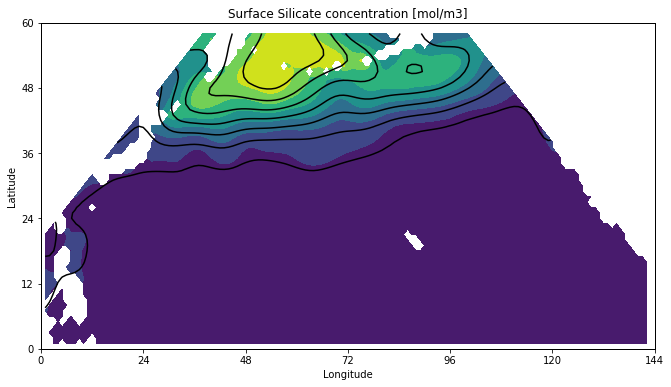

In [11]:
urlim = '/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_monthly_silicate.nc'

woa13_sisurf = xr.DataArray((xr.open_dataset(urlim,decode_times=False)['i_an'])
                             .roll(lon=180,roll_coords=False).data*perl_2_perkg/molperm3_2_umolperkg,
                             coords=[np.arange(0.5,12.5,1), woa13_sponge.depth.data[0:37], woa13_sponge.lat.data, woa13_sponge.lon.data], 
                             dims=['time','depth','lat', 'lon'])

ismooth_surf = gaussian_filter(woa13_sisurf \
                              .where(woa13_sponge.pacific_mask==1).isel(depth=0).sel(lat=slice(0,60)).sel(lon=slice(116,260)).mean("time").ffill('lat').bfill('lon'),
                              sigma=(2.5,2.5))
f5, f5ax = plt.subplots(figsize=(11,6),ncols=1,nrows=1)
f5cax=f5ax.contourf(woa13_sisurf.mean("time").where(woa13_sponge.pacific_mask==1).isel(depth=0).sel(lat=slice(0,60)).sel(lon=slice(116,260)).where(depth_linslp[0:720:10,0:1440:10]<0))
f5ax.contour(np.where(depth_linslp[0:610:10,0:1440:10]<0,ismooth_surf,np.nan),colors='k')
f5ax.set(xlim=(0,144),xticks=np.arange(0,168,24),ylim=(0,60),yticks=np.arange(0,72,12),
            title='Surface Silicate concentration [mol/m3]',xlabel='Longitude',ylabel='Latitude')
plt.show()

Interpolate on to 0.1°, 1°, and 3° grids

In [12]:
def calc_wind_speed(ustress,vstress):
    # Inversion of wind speed from wind stress as in MITgcm/pkg/exf/exf_wind.F
    wspd       = np.zeros_like(ustress)
    atmrho     = 1.2
    ustofu11   = 0.381800
    u11        = 11.     
    clindrag_1 = 0.000065
    clindrag_2 = 0.000490
    cquadrag_1 = clindrag_1/u11/2
    cquadrag_2 = clindrag_1*u11/2 + clindrag_2
    
    usSq    = ustress*ustress+vstress*vstress
    wStress = np.sqrt(usSq)
    cw      = ustress/wStress
    sw      = vstress/wStress

    recip_sqrtRhoA = 1.0 / np.sqrt(atmrho)

    ustar = np.sqrt(wStress)*recip_sqrtRhoA
    
    tmplt1 = -cquadrag_2/cquadrag_1*(1/2)
    tmpgt1 = clindrag_2/clindrag_1*(1/3)
    tmpgt2 = ustar*ustar/clindrag_1*(1/2)- tmpgt1*tmpgt1*tmpgt1
    tmpgt3 = np.sqrt( ustar*ustar/clindrag_1*(ustar*ustar/clindrag_1*(1/4) - tmpgt1*tmpgt1*tmpgt1 ))
    tmpgt4 = (tmpgt2 + tmpgt3)**(1/3)
    return np.where(ustar < ustofu11,
                  np.sqrt( tmplt1 + np.sqrt(tmplt1*tmplt1 + ustar*ustar/cquadrag_1)),
                  tmpgt4 + tmpgt1*tmpgt1 / tmpgt4 - tmpgt1)

forcing_0_1deg = xr.Dataset(
   {
       "depth_linslp": (["YC", "XC"], depth_linslp),
       "depth_expslp": (["YC", "XC"], depth_expslp),
       "latc"        : (["YC", "XC"], YC),
       "lonc"        : (["YC", "XC"], XC),
   },
   coords={
       "XC":  ("XC", XC[0,:]),
       "YC":  ("YC", YC[:,0]),
       "RF":  ("RF",rF),
       "RC":  ("RC",rC),
       "time":("time",np.arange(0.5,12.5,1))
   })

forcing_1_0adeg = xr.Dataset(
   {
       "sst_relax" : (["YC", "XC", "time"], trmon),
       "sss_relax" : (["YC", "XC", "time"], srmon),
       "theta_sbdy": (["RC", "YC", "XC"], np.tile(tsmooth[:,np.newaxis,:],(1,60,1))),
       "salt_sbdy" : (["RC", "YC", "XC"], np.tile(ssmooth[:,np.newaxis,:],(1,60,1))),
       "no3_sbdy"  : (["RC", "YC", "XC"], np.tile(nsmooth[:,np.newaxis,:],(1,60,1))),
       "po4_sbdy"  : (["RC", "YC", "XC"], np.tile(psmooth[:,np.newaxis,:],(1,60,1))),
       "do2_sbdy"  : (["RC", "YC", "XC"], np.tile(osmooth[:,np.newaxis,:],(1,60,1))),
       "sit_sbdy"  : (["RC", "YC", "XC"], np.tile(ismooth[:,np.newaxis,:],(1,60,1))),
       "sit_surf"  : (["time","YC", "XC"], np.tile(ismooth_surf,(12,1,1)))
   },
   coords={
       "XC": ("XC", np.arange(0.5,144.5,1.0)),
       "YC": ("YC", woa13_sponge.lat.isel(lat=slice(90 ,150))),
       "RC": ("RC", woa13_sponge.depth),
       "time":("time",np.arange(0.5,12.5,1))
   })

forcing_1_0bdeg = xr.Dataset(
   {
       "dic_sbdy"  : (["RC","YC", "XC"], np.tile(csmooth[:,np.newaxis,:],(1,60,1))),
       "alk_sbdy"  : (["RC","YC", "XC"], np.tile(asmooth[:,np.newaxis,:],(1,60,1))),
   },
   coords={
       "XC": ("XC", np.arange(0.5,144.5,1.0)),
       "YC": ("YC", glodap_sponge.lat.isel(lat=slice(90 ,150))),
       "RC": ("RC", glodap_sponge.depth),
       "time":("time",np.arange(0.5,12.5,1))
   })

forcing_2_8deg = xr.Dataset(
   {
       "taux_forc":  (["YC", "XC", "time"], txmon),
       "tauy_forc":  (["YC", "XC", "time"], tymon),
       "wspd_forc":  (["YC", "XC", "time"], calc_wind_speed(txmon,tymon)),
   },
   coords={
       "XC": ("XC", grid_data.XC.isel(XC=slice(0 ,53))),
       "YC": ("YC", grid_data.YC.isel(YC=slice(32,54))),
       "RF": ("RF",rF),
       "RC": ("RC",rC),
       "time":("time",np.arange(0.5,12.5,1))
   })


forcing_1_0deg = xr.Dataset(
   coords={
       "XC": ("XC", np.arange(0.5,144.5,1.0)),
       "YC": ("YC", woa13_sponge.lat.isel(lat=slice(90 ,150))),
       "RF": ("RF",rF),
       "RC": ("RC",rC),
       "time":("time",np.arange(0.5,12.5,1))
   })

forcing_2_0deg = xr.Dataset(
   coords={
       "XC": ("XC", np.arange(1,144,2)),
       "YC": ("YC", np.arange(1,60 ,2)),
       "RF": ("RF",rF),
       "RC": ("RC",rC),
       "time":("time",np.arange(0.5,12.5,1))
   })

forcing_3_0deg = xr.Dataset(
   coords={
       "XC": ("XC", np.arange(1.5,144,3)),
       "YC": ("YC", np.arange(1.5,60 ,3)),
       "RF": ("RF",rF),
       "RC": ("RC",rC),
       "time":("time",np.arange(0.5,12.5,1))
   })

# Interpolate the different fields onto the different grids
for item in ["depth_linslp","depth_expslp"]:
    forcing_1_0deg[item]=forcing_0_1deg[item].interp(coords={'YC':forcing_1_0deg.YC,'XC':forcing_1_0deg.XC},assume_sorted=True)
    forcing_2_0deg[item]=forcing_0_1deg[item].interp(coords={'YC':forcing_2_0deg.YC,'XC':forcing_2_0deg.XC},assume_sorted=True)
    forcing_3_0deg[item]=forcing_0_1deg[item].interp(coords={'YC':forcing_3_0deg.YC,'XC':forcing_3_0deg.XC},assume_sorted=True)

for item in ["sst_relax","sss_relax","sit_surf"]:
    forcing_0_1deg[item]=forcing_1_0adeg[item].interp(coords={'YC':forcing_0_1deg.YC,'XC':forcing_0_1deg.XC},assume_sorted=True)
    forcing_1_0deg[item]=forcing_1_0adeg[item].interp(coords={'YC':forcing_1_0deg.YC,'XC':forcing_1_0deg.XC},assume_sorted=True)
    forcing_2_0deg[item]=forcing_1_0adeg[item].interp(coords={'YC':forcing_2_0deg.YC,'XC':forcing_2_0deg.XC},assume_sorted=True)
    forcing_3_0deg[item]=forcing_1_0adeg[item].interp(coords={'YC':forcing_3_0deg.YC,'XC':forcing_3_0deg.XC},assume_sorted=True)

for item in ["theta_sbdy","salt_sbdy","no3_sbdy","po4_sbdy","do2_sbdy","sit_sbdy"]:
    forcing_0_1deg[item]=forcing_1_0adeg[item].interp(coords={'RC':forcing_0_1deg.RC,'YC':forcing_0_1deg.YC,'XC':forcing_0_1deg.XC},assume_sorted=True)
    forcing_1_0deg[item]=forcing_1_0adeg[item].interp(coords={'RC':forcing_1_0deg.RC,'YC':forcing_1_0deg.YC,'XC':forcing_1_0deg.XC},assume_sorted=True)
    forcing_2_0deg[item]=forcing_1_0adeg[item].interp(coords={'RC':forcing_2_0deg.RC,'YC':forcing_2_0deg.YC,'XC':forcing_2_0deg.XC},assume_sorted=True)
    forcing_3_0deg[item]=forcing_1_0adeg[item].interp(coords={'RC':forcing_3_0deg.RC,'YC':forcing_3_0deg.YC,'XC':forcing_3_0deg.XC},assume_sorted=True)
    
for item in forcing_1_0bdeg.keys():
    forcing_0_1deg[item]=forcing_1_0bdeg[item].interp(coords={'RC':forcing_0_1deg.RC,'YC':forcing_0_1deg.YC,'XC':forcing_0_1deg.XC},assume_sorted=True)
    forcing_1_0deg[item]=forcing_1_0bdeg[item].interp(coords={'RC':forcing_1_0deg.RC,'YC':forcing_1_0deg.YC,'XC':forcing_1_0deg.XC},assume_sorted=True)
    forcing_2_0deg[item]=forcing_1_0bdeg[item].interp(coords={'RC':forcing_2_0deg.RC,'YC':forcing_2_0deg.YC,'XC':forcing_2_0deg.XC},assume_sorted=True)
    forcing_3_0deg[item]=forcing_1_0bdeg[item].interp(coords={'RC':forcing_3_0deg.RC,'YC':forcing_3_0deg.YC,'XC':forcing_3_0deg.XC},assume_sorted=True)
    
for item in forcing_2_8deg.keys():
    forcing_0_1deg[item]=forcing_2_8deg[item].interp(coords={'YC':forcing_0_1deg.YC,'XC':forcing_0_1deg.XC},assume_sorted=True)
    forcing_1_0deg[item]=forcing_2_8deg[item].interp(coords={'YC':forcing_1_0deg.YC,'XC':forcing_1_0deg.XC},assume_sorted=True)
    forcing_3_0deg[item]=forcing_2_8deg[item].interp(coords={'YC':forcing_3_0deg.YC,'XC':forcing_3_0deg.XC},assume_sorted=True)
    forcing_2_0deg[item]=forcing_2_8deg[item].interp(coords={'YC':forcing_2_0deg.YC,'XC':forcing_2_0deg.XC},assume_sorted=True)

    
# RBCS Package requires a mask
forcing_0_1deg['rbcs_mask'] = xr.DataArray(np.zeros((forcing_0_1deg.dims['YC'], forcing_0_1deg.dims['XC'], forcing_0_1deg.dims['RC'])), 
                                             coords=[forcing_0_1deg.YC.data, forcing_0_1deg.XC.data, forcing_0_1deg.RC.data], 
                                             dims=['YC', 'XC', 'RC'])


forcing_1_0deg['rbcs_mask'] = xr.DataArray(np.zeros((forcing_1_0deg.dims['YC'], forcing_1_0deg.dims['XC'], forcing_1_0deg.dims['RC'])), 
                                             coords=[forcing_1_0deg.YC.data, forcing_1_0deg.XC.data, forcing_1_0deg.RC.data], 
                                             dims=['YC', 'XC', 'RC'])


forcing_2_0deg['rbcs_mask'] = xr.DataArray(np.zeros((forcing_2_0deg.dims['YC'], forcing_2_0deg.dims['XC'], forcing_2_0deg.dims['RC'])), 
                                             coords=[forcing_2_0deg.YC.data, forcing_2_0deg.XC.data, forcing_2_0deg.RC.data], 
                                             dims=['YC', 'XC', 'RC'])

forcing_3_0deg['rbcs_mask'] = xr.DataArray(np.zeros((forcing_3_0deg.dims['YC'], forcing_3_0deg.dims['XC'], forcing_3_0deg.dims['RC'])), 
                                             coords=[forcing_3_0deg.YC.data, forcing_3_0deg.XC.data, forcing_3_0deg.RC.data], 
                                             dims=['YC', 'XC', 'RC'])

# Apply relaxation of the Southern Boundary over 3 degrees (the field itself is the same longitude slice repeated)
# NB that the first ~1 degree is blocked topography
forcing_0_1deg['rbcs_mask'][0:32,:,:] = 1.0
forcing_1_0deg['rbcs_mask'][0:5 ,:,:] = 1.0
forcing_2_0deg['rbcs_mask'][0:2 ,:,:] = 1.0
forcing_3_0deg['rbcs_mask'][0:2 ,:,:] = 1.0

# Reorder dimensions to be consistent
forcing_0_1deg = forcing_0_1deg.transpose("time","RF","RC","YC","XC")
forcing_1_0deg = forcing_1_0deg.transpose("time","RF","RC","YC","XC")
forcing_2_0deg = forcing_2_0deg.transpose("time","RF","RC","YC","XC")
forcing_3_0deg = forcing_3_0deg.transpose("time","RF","RC","YC","XC")


<ipython-input-12-3e06e835a1c9>:24: RuntimeWarning: invalid value encountered in sqrt
  tmpgt3 = np.sqrt( ustar*ustar/clindrag_1*(ustar*ustar/clindrag_1*(1/4) - tmpgt1*tmpgt1*tmpgt1 ))


Write out to binary files

In [13]:
for grid in ['forcing_0_1deg','forcing_1_0deg','forcing_3_0deg']:
    for item in eval(grid+'.keys()'):
        fname = '/Users/jml1/MItgcm/MITgcm_67r/Idealized_north_pacific_ecosystem/input/'+grid+'_'+item+'.bin'
        tmp   = eval(grid+'.'+item)
        binin = tmp.fillna(0).data.astype('single').byteswap(True).tofile(fname)

### For runs extended to 12$^\circ$S (no sponge layer) have to repeat process...
### Initialize bathymetry
Load "depth_2d.bin" from the offline_run_template for basin shape

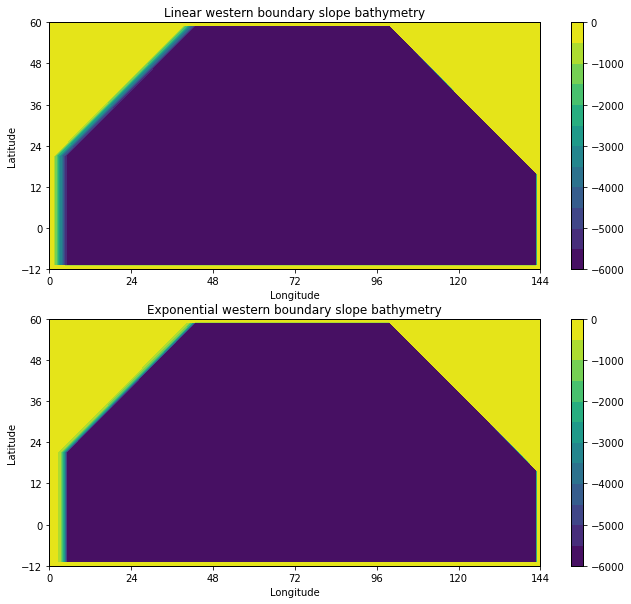

In [14]:
YG=np.append(np.flipud(-YG[1:121,:]),YG,axis=0)
XG=np.append(XG[1:121,:],XG,axis=0)

YC=np.append(np.flipud(-YC[0:120,:]),YC,axis=0)
XC=np.append(XC[0:120,:],XC,axis=0)

depth_linslp[0:10,:] = depth_linslp[10,:]
depth_linslp=np.append(depth_linslp[0:120,:],depth_linslp,axis=0)
depth_expslp[0:10,:] = depth_expslp[10,:]
depth_expslp=np.append(depth_expslp[0:120,:],depth_expslp,axis=0)

# Add a 1 degree boundary around the edge to prevent periodicity
depth_linslp[  0:10,   :  ]=0
depth_linslp[-10:-1,   :  ]=0
depth_linslp[   :  ,  0:10]=0
depth_linslp[   :  ,-10:-1]=0

depth_expslp[  0:10,   :  ]=0
depth_expslp[-10:-1,   :  ]=0
depth_expslp[   :  ,  0:10]=0
depth_expslp[   :  ,-10:-1]=0

f7, f7ax = plt.subplots(figsize=(11,10),ncols=1,nrows=2)
f7cax=f7ax.copy()
f7cax[0]=f7ax[0].contourf(XC,YC,depth_linslp,levels=np.arange(-6000,500,500),cmap='viridis')
plt.colorbar(f7cax[0],ax=f7ax[0])
f7ax[0].set(xlim=(0,144),xticks=np.arange(0,168,24),ylim=(-12,60),yticks=np.arange(-12,72,12),
            title='Linear western boundary slope bathymetry',xlabel='Longitude',ylabel='Latitude')
f7cax[1]=f7ax[1].contourf(XC,YC,depth_expslp,levels=np.arange(-6000,500,500),cmap='viridis')
plt.colorbar(f7cax[1],ax=f7ax[1])
f7ax[1].set(xlim=(0,144),xticks=np.arange(0,168,24),ylim=(-12,60),yticks=np.arange(-12,72,12),
            title='Exponential western boundary slope bathymetry',xlabel='Longitude',ylabel='Latitude')
plt.show()

### Load climatologies for forcing
Linear annual-average temperature relaxation

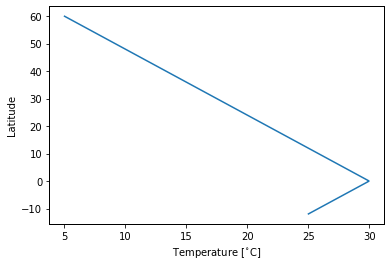

In [15]:
tref=30-(25/60)*np.abs(YC)
plt.plot(np.mean(tref,axis=1),np.mean(YC,axis=1))
plt.xlabel('Temperature [$^{\circ}$C]')
plt.ylabel('Latitude')
plt.show()

Use World Ocean Atlas 2013 Pacific data to make a seasonally varying version that averages out to the annual version above

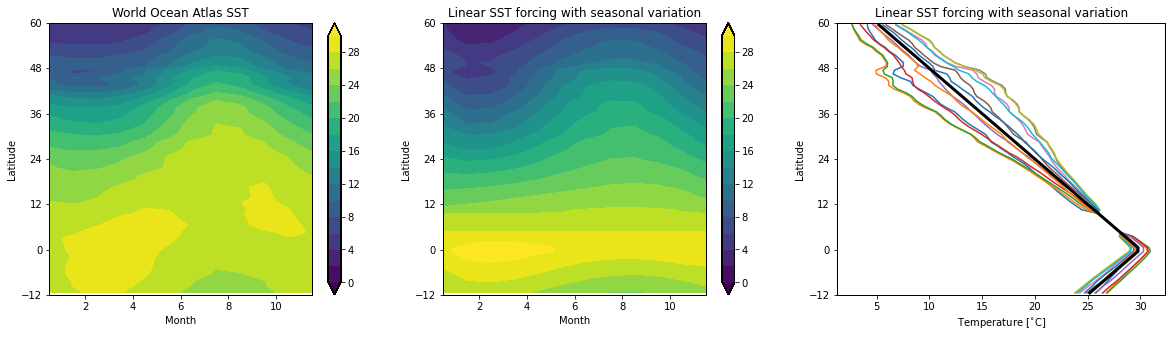

In [16]:
trmon=np.tile(30-(25/60)*np.abs(np.arange(-11.5,60.5,1)),[12,1]).T

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    ii=0
    for elat in np.arange(-11.5,60.5,1):
        if np.abs(woa13_data.t_an.isel(depth=0).where(woa13_data.pacific_mask.isel(depth=0)==0).where(woa13_data.lat>=-12).mean('lon').sel(lat=elat,method='nearest').max() - 
                  woa13_data.t_an.isel(depth=0).where(woa13_data.pacific_mask.isel(depth=0)==0).where(woa13_data.lat>=-12).mean('lon').sel(lat=elat,method='nearest').min()) > 1.75:
            coef = np.polyfit(np.arange(0.5,12.5,1), woa13_data.t_an.isel(depth=0).where(woa13_data.pacific_mask.isel(depth=0)==0).where(woa13_data.lat>=-12).mean('lon').sel(lat=elat,method='nearest'), 4)
            seas = coef[0]*np.arange(0.5,12.5,1)**4 \
                  +coef[1]*np.arange(0.5,12.5,1)**3 \
                  +coef[2]*np.arange(0.5,12.5,1)**2 \
                  +coef[3]*np.arange(0.5,12.5,1)    \
                  +coef[4]
            # make sure seasonal variation is smooth from DEC - JAN
            seas[-1]=np.mean((seas[0],seas[-2]))
            # make sure the mean of seasonal variations matches the annual-average reference
            trmon[ii,:]=seas-np.mean(seas)+trmon[ii,0]
        ii += 1

# Tile the latitudinal profiles along the longitudinal direction
trmon=np.tile(trmon[:,np.newaxis,:],[1,144,1])

f8, f8ax = plt.subplots(figsize=(20,5),ncols=3,nrows=1)
f8cax=f8ax.copy()
f8cax[0]=f8ax[0].contourf(np.arange(0.5,12.5,1),woa13_data.lat.isel(lat=slice(78,150)),woa13_data.t_an.isel(depth=0).where(woa13_data.pacific_mask.isel(depth=0)==0).isel(lat=slice(78,150)).mean('lon').T,levels=np.arange(0,32,2),cmap='viridis',extend='both')
plt.colorbar(f8cax[0],ax=f8ax[0])
f8ax[0].set(ylim=(-12,60),yticks=np.arange(-12,72,12),
            title='World Ocean Atlas SST',xlabel='Month',ylabel='Latitude')
f8cax[1]=f8ax[1].contourf(np.arange(0.5,12.5,1),woa13_data.lat.isel(lat=slice(78,150)),np.mean(trmon,axis=1),levels=np.arange(0,32,2),cmap='viridis',extend='both')
plt.colorbar(f8cax[1],ax=f8ax[1])
f8ax[1].set(ylim=(-12,60),yticks=np.arange(-12,72,12),
            title='Linear SST forcing with seasonal variation',xlabel='Month',ylabel='Latitude')
f8ax[2].plot(np.mean(trmon,axis=1),np.tile(np.arange(-11.5,60.5,1),[12,1]).T)
f8ax[2].plot(np.mean(np.mean(trmon,axis=1),axis=1),np.arange(-11.5,60.5,1),color='black',linewidth=3)
f8ax[2].set(ylim=(-12,60),yticks=np.arange(-12,72,12),
            title='Linear SST forcing with seasonal variation',xlabel='Temperature [$^{\circ}$C]',ylabel='Latitude')
plt.show()

Salinity relaxation doesn't change that much over a year, so could just prescribe a step-function with latitude

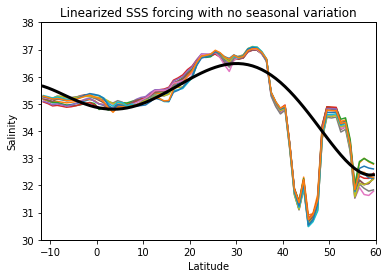

In [17]:
# Fit surface salinity to a 5th order polynomial, it gives the best distribution of low S at the equator,
# higher in the midlats and low again in the subpolar regions.
def objective(x, a, b, c, d, e, f):  return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

popt, pcov = curve_fit(objective, woa13_data.lat.isel(lat=slice(66,150)).values+5,
                                   woa13_data.s_an.isel(depth=0).where(woa13_data.pacific_mask.isel(depth=0)==0).isel(lat=slice(66,150)).mean({'lon','time'}).values)
fitfunc = lambda x: (popt[0] * x) + (popt[1] * x**2) + (popt[2] * x**3) + (popt[3] * x**4) + (popt[4] * x**5) + popt[5]
srmon = np.tile(fitfunc(woa13_data.lat.isel(lat=slice(78,150)).values)[:,np.newaxis,np.newaxis],(1,144,12))

plt.plot(woa13_data.lat.isel(lat=slice(78,150)),woa13_data.s_an.isel(depth=0).where(woa13_data.pacific_mask.isel(depth=0)==0).isel(lat=slice(78,150)).mean('lon').T)
plt.plot(woa13_data.lat.isel(lat=slice(78,150)),srmon[:,0,0],color='k',linewidth=3)
plt.xlim(-12,60)
plt.ylim(30,38)
plt.title('Linearized SSS forcing with no seasonal variation')
plt.xlabel('Latitude')
plt.ylabel('Salinity')
plt.show()

Zonal wind stress is latitudinally, and seasonally variable, but meridional wind stress is probably better off being constant

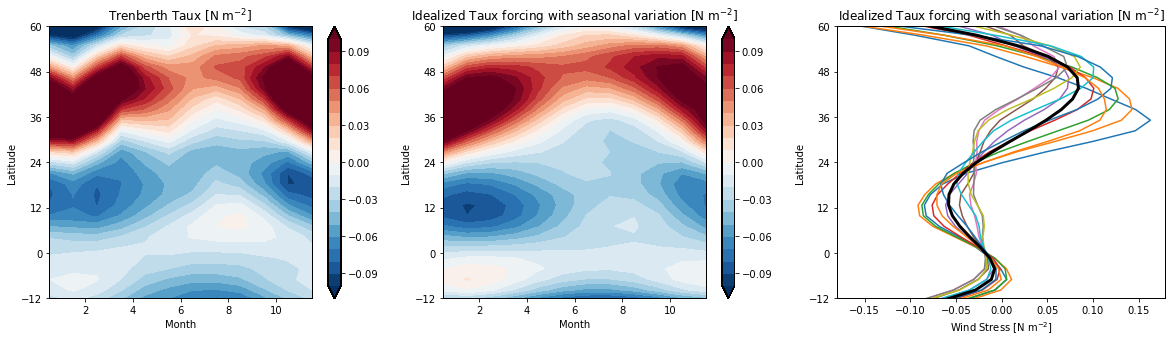

In [18]:
# fit the zonally- and annually-averaged zonal wind stress profile and use as the reference
coef = np.polyfit(grid_data.YC.isel(YC=slice(27,54)),taux.where(grid_data.cmask_pacific.isel(ZC=0)==1).isel(YC=slice(27,54)).mean({"time",'XC'}),5)
ref  = coef[0]*grid_data.YC.isel(YC=slice(27,54))**5 \
      +coef[1]*grid_data.YC.isel(YC=slice(27,54))**4 \
      +coef[2]*grid_data.YC.isel(YC=slice(27,54))**3 \
      +coef[3]*grid_data.YC.isel(YC=slice(27,54))**2 \
      +coef[4]*grid_data.YC.isel(YC=slice(27,54))    \
      +coef[5]

txmon=np.tile(ref,[12,1]).T

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    ii=0
    for elat in grid_data.YC.isel(YC=slice(27,54)):
        if np.abs(taux.where(grid_data.cmask_pacific.isel(ZC=0)==1).mean('XC').sel(YC=elat,method='nearest').max() - 
                  taux.where(grid_data.cmask_pacific.isel(ZC=0)==1).mean('XC').sel(YC=elat,method='nearest').min()) > 0:
            coef = np.polyfit(np.arange(0.5,12.5,1),taux.where(grid_data.cmask_pacific.isel(ZC=0)==1).mean('XC').sel(YC=elat,method='nearest'),4)
            seas = coef[0]*np.arange(0.5,12.5,1)**4 \
                  +coef[1]*np.arange(0.5,12.5,1)**3 \
                  +coef[2]*np.arange(0.5,12.5,1)**2 \
                  +coef[3]*np.arange(0.5,12.5,1)    \
                  +coef[4]
            # make sure seasonal variation is smooth from DEC - JAN
            seas[-1]=np.mean((seas[0],seas[-2]))
            # make sure the mean of seasonal variations matches the annual-average reference
            txmon[ii,:]=seas-np.mean(seas)+ref[ii].values
        ii += 1

# Tile the latitudinal profiles along the longitudinal direction
txmon=np.tile(txmon[:,np.newaxis,:],[1,53,1])
tymon=np.zeros_like(txmon)

f9, f9ax = plt.subplots(figsize=(20,5),ncols=3,nrows=1)
f9cax=f9ax.copy()
f9cax[0]=f9ax[0].contourf(np.arange(0.5,12.5,1),taux.YC.isel(YC=slice(27,54)),taux.where(grid_data.cmask_pacific.isel(ZC=0)==1).isel(YC=slice(27,54)).mean({'XC'}).T,levels=np.arange(-0.1,0.11,0.01),cmap='RdBu_r',extend='both')
plt.colorbar(f9cax[0],ax=f9ax[0])
f9ax[0].set(ylim=(-12,60),yticks=np.arange(-12,72,12),
            title='Trenberth Taux [N m$^{-2}$]',xlabel='Month',ylabel='Latitude')
f9cax[1]=f9ax[1].contourf(np.arange(0.5,12.5,1),taux.YC.isel(YC=slice(27,54)),np.mean(txmon,axis=1),levels=np.arange(-0.1,0.11,0.01),cmap='RdBu_r',extend='both')
plt.colorbar(f9cax[1],ax=f9ax[1])
f9ax[1].set(ylim=(-12,60),yticks=np.arange(-12,72,12),
            title='Idealized Taux forcing with seasonal variation [N m$^{-2}$]',xlabel='Month',ylabel='Latitude')
f9ax[2].plot(np.mean(txmon,axis=1),np.tile(taux.YC.isel(YC=slice(27,54)),[12,1]).T)
f9ax[2].plot(np.mean(np.mean(txmon,axis=1),axis=1),taux.YC.isel(YC=slice(27,54)),color='black',linewidth=3)
f9ax[2].set(ylim=(-12,60),yticks=np.arange(-12,72,12),
            title='Idealized Taux forcing with seasonal variation [N m$^{-2}$]',xlabel='Wind Stress [N m$^{-2}$]',ylabel='Latitude')
plt.show()

Need a surface silicate field for CO2 fluxes

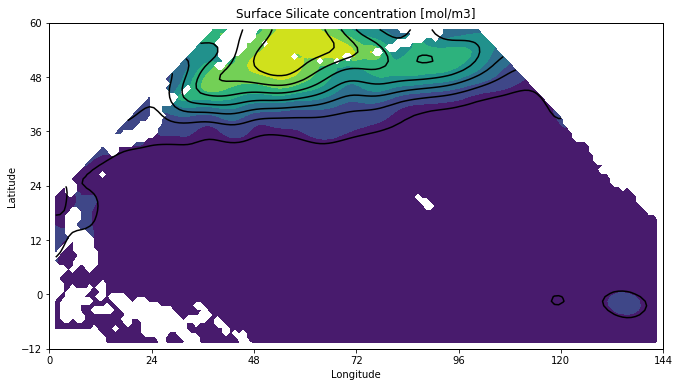

In [19]:
urlim = '/Users/jml1/Dropbox_Work/cfluxes_matlab/obs/woa13_monthly_silicate.nc'

woa13_sisurf = xr.DataArray((xr.open_dataset(urlim,decode_times=False)['i_an'])
                             .roll(lon=180,roll_coords=False).data*perl_2_perkg/molperm3_2_umolperkg,
                             coords=[np.arange(0.5,12.5,1), woa13_sponge.depth.data[0:37], woa13_sponge.lat.data, woa13_sponge.lon.data], 
                             dims=['time','depth','lat', 'lon'])

ismooth_surf = gaussian_filter(woa13_sisurf \
                              .where(woa13_sponge.pacific_mask==1).isel(depth=0).sel(lat=slice(-12,60)).sel(lon=slice(116,260)).mean("time").ffill('lat').bfill('lon'),
                              sigma=(2.5,2.5))

f10, f10ax = plt.subplots(figsize=(11,6),ncols=1,nrows=1)
f10cax=f10ax.contourf(woa13_sisurf.lon.sel(lon=slice(0,144)),woa13_sisurf.lat.sel(lat=slice(-12,60)),woa13_sisurf.mean("time").where(woa13_sponge.pacific_mask==1).isel(depth=0).sel(lat=slice(-12,60)).sel(lon=slice(116,260)).where(depth_linslp[0:720:10,0:1440:10]<0))
f10ax.contour(woa13_sisurf.lon.sel(lon=slice(0,144)),woa13_sisurf.lat.sel(lat=slice(-12,60)),np.where(depth_linslp[0:730:10,0:1440:10]<0,ismooth_surf,np.nan),colors='k')
f10ax.set(xlim=(0,144),xticks=np.arange(0,168,24),ylim=(-12,60),yticks=np.arange(-12,72,12),
            title='Surface Silicate concentration [mol/m3]',xlabel='Longitude',ylabel='Latitude')
plt.show()

In [20]:
forcing_0_1deg_12s = xr.Dataset(
   {
       "depth_linslp": (["YC", "XC"], depth_linslp),
       "depth_expslp": (["YC", "XC"], depth_expslp),
       "latc"        : (["YC", "XC"], YC),
       "lonc"        : (["YC", "XC"], XC),
   },
   coords={
       "XC":  ("XC", XC[0,:]),
       "YC":  ("YC", YC[:,0]),
       "RF":  ("RF",rF),
       "RC":  ("RC",rC),
       "time":("time",np.arange(0.5,12.5,1))
   })

forcing_1_0adeg_12s = xr.Dataset(
   {
       "sst_relax" : (["YC", "XC", "time"], trmon),
       "sss_relax" : (["YC", "XC", "time"], srmon),
       "theta_sbdy": (["RC", "YC", "XC"], np.tile(tsmooth[:,np.newaxis,:],(1,72,1))),
       "salt_sbdy" : (["RC", "YC", "XC"], np.tile(ssmooth[:,np.newaxis,:],(1,72,1))),
       "no3_sbdy"  : (["RC", "YC", "XC"], np.tile(nsmooth[:,np.newaxis,:],(1,72,1))),
       "po4_sbdy"  : (["RC", "YC", "XC"], np.tile(psmooth[:,np.newaxis,:],(1,72,1))),
       "do2_sbdy"  : (["RC", "YC", "XC"], np.tile(osmooth[:,np.newaxis,:],(1,72,1))),
       "sit_sbdy"  : (["RC", "YC", "XC"], np.tile(ismooth[:,np.newaxis,:],(1,72,1))),
       "sit_surf"  : (["time", "YC", "XC"], np.tile(ismooth_surf,(12,1,1)))

   },
   coords={
       "XC": ("XC", np.arange(0.5,144.5,1.0)),
       "YC": ("YC", woa13_sponge.lat.isel(lat=slice(78 ,150))),
       "RC": ("RC", woa13_sponge.depth),
       "time":("time",np.arange(0.5,12.5,1))
   })


forcing_1_0bdeg_12s = xr.Dataset(
   {
       "dic_sbdy"  : (["RC","YC", "XC"], np.tile(csmooth[:,np.newaxis,:],(1,72,1))),
       "alk_sbdy"  : (["RC","YC", "XC"], np.tile(asmooth[:,np.newaxis,:],(1,72,1))),
   },
   coords={
       "XC": ("XC", np.arange(0.5,144.5,1.0)),
       "YC": ("YC", glodap_sponge.lat.isel(lat=slice(78 ,150))),
       "RC": ("RC", glodap_sponge.depth),
       "time":("time",np.arange(0.5,12.5,1))
   })

forcing_2_8deg_12s = xr.Dataset(
   {
       "taux_forc":  (["YC", "XC", "time"], txmon),
       "tauy_forc":  (["YC", "XC", "time"], tymon),
       "wspd_forc":  (["YC", "XC", "time"], calc_wind_speed(txmon,tymon)),
   },
   coords={
       "XC": ("XC", grid_data.XC.isel(XC=slice(0 ,53))),
       "YC": ("YC", grid_data.YC.isel(YC=slice(27,54))),
       "RF": ("RF",rF),
       "RC": ("RC",rC),
       "time":("time",np.arange(0.5,12.5,1))
   })

forcing_1_0deg_12s = xr.Dataset(
   coords={
       "XC": ("XC", np.arange(0.5,144.5,1.0)),
       "YC": ("YC", woa13_sponge.lat.isel(lat=slice(78 ,150))),
       "RF": ("RF",rF),
       "RC": ("RC",rC),
       "time":("time",np.arange(0.5,12.5,1))
   })

forcing_2_0deg_12s = xr.Dataset(
   coords={
       "XC": ("XC", np.arange(1,144,2)),
       "YC": ("YC", np.arange(-11,60 ,2)),
       "RF": ("RF",rF),
       "RC": ("RC",rC),
       "time":("time",np.arange(0.5,12.5,1))
   })

forcing_3_0deg_12s = xr.Dataset(
   coords={
       "XC": ("XC", np.arange(1.5,144,3)),
       "YC": ("YC", np.arange(-10.5,60 ,3)),
       "RF": ("RF",rF),
       "RC": ("RC",rC),
       "time":("time",np.arange(0.5,12.5,1))
   })

# Interpolate the different fields onto the different grids
for item in ["depth_linslp","depth_expslp"]:
    forcing_1_0deg_12s[item]=forcing_0_1deg_12s[item].interp(coords={'YC':forcing_1_0deg_12s.YC,'XC':forcing_1_0deg_12s.XC},assume_sorted=True)
    forcing_1_0deg_12s[item]=forcing_0_1deg_12s[item].interp(coords={'YC':forcing_1_0deg_12s.YC,'XC':forcing_1_0deg_12s.XC},assume_sorted=True)
    forcing_2_0deg_12s[item]=forcing_0_1deg_12s[item].interp(coords={'YC':forcing_2_0deg_12s.YC,'XC':forcing_2_0deg_12s.XC},assume_sorted=True)
    forcing_3_0deg_12s[item]=forcing_0_1deg_12s[item].interp(coords={'YC':forcing_3_0deg_12s.YC,'XC':forcing_3_0deg_12s.XC},assume_sorted=True)

for item in ["sst_relax","sss_relax","sit_surf"]:
    forcing_0_1deg_12s[item]=forcing_1_0adeg_12s[item].interp(coords={'YC':forcing_0_1deg_12s.YC,'XC':forcing_0_1deg_12s.XC},assume_sorted=True)
    forcing_1_0deg_12s[item]=forcing_1_0adeg_12s[item].interp(coords={'YC':forcing_1_0deg_12s.YC,'XC':forcing_1_0deg_12s.XC},assume_sorted=True)
    forcing_2_0deg_12s[item]=forcing_1_0adeg_12s[item].interp(coords={'YC':forcing_2_0deg_12s.YC,'XC':forcing_2_0deg_12s.XC},assume_sorted=True)
    forcing_3_0deg_12s[item]=forcing_1_0adeg_12s[item].interp(coords={'YC':forcing_3_0deg_12s.YC,'XC':forcing_3_0deg_12s.XC},assume_sorted=True)

for item in ["theta_sbdy","salt_sbdy","no3_sbdy","po4_sbdy","do2_sbdy","sit_sbdy"]:
    forcing_0_1deg_12s[item]=forcing_1_0adeg_12s[item].interp(coords={'RC':forcing_0_1deg_12s.RC,'YC':forcing_0_1deg_12s.YC,'XC':forcing_0_1deg_12s.XC},assume_sorted=True)
    forcing_1_0deg_12s[item]=forcing_1_0adeg_12s[item].interp(coords={'RC':forcing_1_0deg_12s.RC,'YC':forcing_1_0deg_12s.YC,'XC':forcing_1_0deg_12s.XC},assume_sorted=True)
    forcing_2_0deg_12s[item]=forcing_1_0adeg_12s[item].interp(coords={'RC':forcing_2_0deg_12s.RC,'YC':forcing_2_0deg_12s.YC,'XC':forcing_2_0deg_12s.XC},assume_sorted=True)
    forcing_3_0deg_12s[item]=forcing_1_0adeg_12s[item].interp(coords={'RC':forcing_3_0deg_12s.RC,'YC':forcing_3_0deg_12s.YC,'XC':forcing_3_0deg_12s.XC},assume_sorted=True)
    
for item in forcing_1_0bdeg.keys():
    forcing_0_1deg_12s[item]=forcing_1_0bdeg_12s[item].interp(coords={'RC':forcing_0_1deg_12s.RC,'YC':forcing_0_1deg_12s.YC,'XC':forcing_0_1deg_12s.XC},assume_sorted=True)
    forcing_1_0deg_12s[item]=forcing_1_0bdeg_12s[item].interp(coords={'RC':forcing_1_0deg_12s.RC,'YC':forcing_1_0deg_12s.YC,'XC':forcing_1_0deg_12s.XC},assume_sorted=True)
    forcing_2_0deg_12s[item]=forcing_1_0bdeg_12s[item].interp(coords={'RC':forcing_2_0deg_12s.RC,'YC':forcing_2_0deg_12s.YC,'XC':forcing_2_0deg_12s.XC},assume_sorted=True)
    forcing_3_0deg_12s[item]=forcing_1_0bdeg_12s[item].interp(coords={'RC':forcing_3_0deg_12s.RC,'YC':forcing_3_0deg_12s.YC,'XC':forcing_3_0deg_12s.XC},assume_sorted=True)
   
for item in forcing_2_8deg_12s.keys():
    forcing_0_1deg_12s[item]=forcing_2_8deg_12s[item].interp(coords={'YC':forcing_0_1deg_12s.YC,'XC':forcing_0_1deg_12s.XC},assume_sorted=True)
    forcing_1_0deg_12s[item]=forcing_2_8deg_12s[item].interp(coords={'YC':forcing_1_0deg_12s.YC,'XC':forcing_1_0deg_12s.XC},assume_sorted=True)
    forcing_3_0deg_12s[item]=forcing_2_8deg_12s[item].interp(coords={'YC':forcing_3_0deg_12s.YC,'XC':forcing_3_0deg_12s.XC},assume_sorted=True)
    forcing_2_0deg_12s[item]=forcing_2_8deg_12s[item].interp(coords={'YC':forcing_2_0deg_12s.YC,'XC':forcing_2_0deg_12s.XC},assume_sorted=True)

# RBCS Package requires a mask
forcing_0_1deg_12s['rbcs_mask'] = xr.DataArray(np.zeros((forcing_0_1deg_12s.dims['YC'], forcing_0_1deg_12s.dims['XC'], forcing_0_1deg_12s.dims['RC'])), 
                                             coords=[forcing_0_1deg_12s.YC.data, forcing_0_1deg_12s.XC.data, forcing_0_1deg_12s.RC.data], 
                                             dims=['YC', 'XC', 'RC'])


forcing_1_0deg_12s['rbcs_mask'] = xr.DataArray(np.zeros((forcing_1_0deg_12s.dims['YC'], forcing_1_0deg_12s.dims['XC'], forcing_1_0deg_12s.dims['RC'])), 
                                             coords=[forcing_1_0deg_12s.YC.data, forcing_1_0deg_12s.XC.data, forcing_1_0deg_12s.RC.data], 
                                             dims=['YC', 'XC', 'RC'])


forcing_2_0deg_12s['rbcs_mask'] = xr.DataArray(np.zeros((forcing_2_0deg_12s.dims['YC'], forcing_2_0deg_12s.dims['XC'], forcing_2_0deg_12s.dims['RC'])), 
                                             coords=[forcing_2_0deg_12s.YC.data, forcing_2_0deg_12s.XC.data, forcing_2_0deg_12s.RC.data], 
                                             dims=['YC', 'XC', 'RC'])

forcing_3_0deg_12s['rbcs_mask'] = xr.DataArray(np.zeros((forcing_3_0deg_12s.dims['YC'], forcing_3_0deg_12s.dims['XC'], forcing_3_0deg_12s.dims['RC'])), 
                                             coords=[forcing_3_0deg_12s.YC.data, forcing_3_0deg_12s.XC.data, forcing_3_0deg_12s.RC.data], 
                                             dims=['YC', 'XC', 'RC'])

# Apply relaxation of the Southern Boundary over 3 degrees (the field itself is the same longitude slice repeated)
# NB that the first row or two are blocked topography
forcing_0_1deg_12s['rbcs_mask'][0:32,:,:] = 1.0
forcing_1_0deg_12s['rbcs_mask'][0:5 ,:,:] = 1.0
forcing_2_0deg_12s['rbcs_mask'][0:2 ,:,:] = 1.0
forcing_3_0deg_12s['rbcs_mask'][0:2 ,:,:] = 1.0

# Reorder dimensions to be consistent
forcing_0_1deg_12s = forcing_0_1deg_12s.transpose("time","RF","RC","YC","XC")
forcing_1_0deg_12s = forcing_1_0deg_12s.transpose("time","RF","RC","YC","XC")
forcing_2_0deg_12s = forcing_2_0deg_12s.transpose("time","RF","RC","YC","XC")
forcing_3_0deg_12s = forcing_3_0deg_12s.transpose("time","RF","RC","YC","XC")

<ipython-input-12-3e06e835a1c9>:24: RuntimeWarning: invalid value encountered in sqrt
  tmpgt3 = np.sqrt( ustar*ustar/clindrag_1*(ustar*ustar/clindrag_1*(1/4) - tmpgt1*tmpgt1*tmpgt1 ))


Write out to binary files

In [21]:
for grid in ['forcing_0_1deg_12s','forcing_1_0deg_12s','forcing_3_0deg_12s']:
    for item in eval(grid+'.keys()'):
        fname = '/Users/jml1/MItgcm/MITgcm_67r/Idealized_north_pacific_ecosystem/input/'+grid+'_'+item+'.bin'
        tmp   = eval(grid+'.'+item)
        binin = tmp.fillna(0).data.astype('single').byteswap(True).tofile(fname)